# Question 3
### 3.1 Background
<span style="color:pink">
The radial metallicity relation is a function that describes the change of metallicity - here
the gas phase metallicity A(O) = log10(NO/NH) + 12 - along the galactocentric cylindrical
radius RGal.. Understanding the radial metallicity gradient in galaxies provides critical
insights into their formation and evolutionary processes, such as inside-out formation,
gas accretion, outflows, and radial migration. A lot of work has been done through
observational studies (e.g. Ho et al., 2017, ApJ, 846, 39) and a few simulations (e.g.
Grand et al., 2016, MNRAS, 460, 94), but more works needs to be done to understand
the radial metallicity gradient!
Your colleague has just finished an exciting cosmological simulation that traces the
gas phase metallicity for a Milky Way analogue, that is, a spiral galaxy. They have
limited the simulation data to the positions (x, y, z) of the innermost gas particles
(RGal. < 25 kpc) and their gas phase metallicity A(O) and uploaded them as a FITS
file on github  
</span>

### 3.2 Task
<span style="color:pink">
Download the file from the link above into data/. Load the file with python and then
perform the following tasks to create figures that are saved in figures/:
</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

In [65]:
# Load the FITS file
file_path = 'data/xyz_positions_and_oxygen_ao.fits'
with fits.open(file_path) as hdul:
    hdul.info()  # Gives an overview of the HDU structure
    data = hdul[1].data  # Usually the data is in the first extension

# Check the column names
print(data.columns.names)

Filename: data/xyz_positions_and_oxygen_ao.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (678,)   uint8   
  1  /Users/buder/Simulations/preparing_NIHAO/NIHAO_prepared/NIHAO_g8.26e    1 BinTableHDU     21   511520R x 4C   [E, E, E, D]   
['x', 'y', 'z', 'A_O']


In [ ]:
# Extract positions and metallicity
x = data['x']
y = data['y']
z = data['z']
AO = data['A_O'] 

# Compute cylindrical galactocentric radius
R_gal = np.sqrt(x**2 + y**2)

In [ ]:
def linear_func(R, m, b):
    return m * R + b

# Fit the linear function to the data
optimal_param, cov_matrix = curve_fit(linear_func, R_gal, AO)
slope, intercept = optimal_param
slope_err, intercept_err = np.sqrt(np.diag(cov_matrix))


# Compute fitted values and residuals
AO_fit = linear_func(R_gal, slope, intercept)
residuals = AO - AO_fit

Slope = -0.0342 ± 0.0000
Intercept = 9.1278 ± 0.0002


<span style="color:pink">
1) Plot a 2-panel figure:

- Logarithmic density plot of RGal. vs. A(O), with a linear fit and legend.

- Residuals of the fit, RGal. vs. ∆A(O)

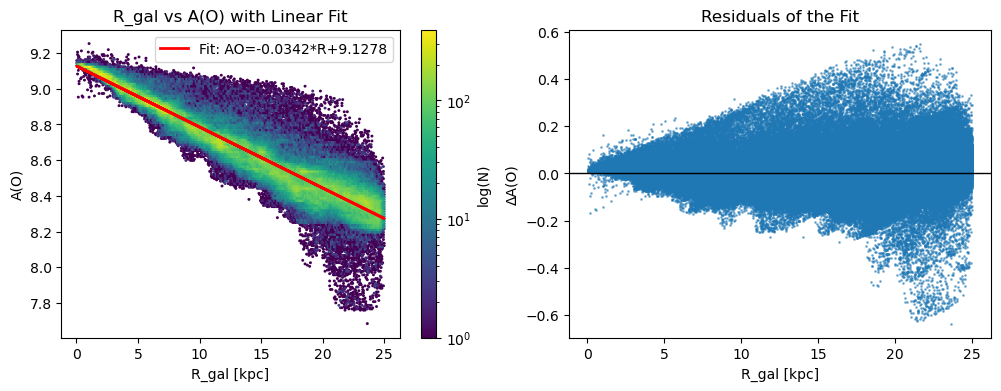

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Panel (a): Log-density plot of R_gal vs AO
hb = ax[0].hexbin(R_gal, AO, gridsize=200, cmap='viridis', bins='log')
ax[0].plot(R_gal, AO_fit, color='red', lw=2, label=f'Fit: AO={slope:.4f}*R+{intercept:.4f}')
ax[0].set_xlabel('R_gal [kpc]')
ax[0].set_ylabel('A(O)')
ax[0].legend()
ax[0].set_title('R_gal vs A(O) with Linear Fit')
fig.colorbar(hb, ax=ax[0], label='log(N)')

# Panel (b): Residuals
ax[1].scatter(R_gal, residuals, s=1, alpha=0.5)
ax[1].axhline(0, color='black', lw=1)
ax[1].set_xlabel('R_gal [kpc]')
ax[1].set_ylabel('ΔA(O)')
ax[1].set_title('Residuals of the Fit')
plt.savefig('figures/RGal_vs_AO_fit_and_residuals.png')
plt.show()

<span style="color:pink">
2) Use a python fitting tool to fit a linear function to the data, reporting the intercept
and slope with uncertainties. Include any hyperparameters used.
</span>

In [66]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE = {rmse:.4f}")

print(f"Slope = {slope:.4f} ± {slope_err:.4f}")
print(f"Intercept = {intercept:.4f} ± {intercept_err:.4f}")

RMSE = 0.0726
Slope = -0.0342 ± 0.0000
Intercept = 9.1278 ± 0.0002


<span style="color:pink">
3) Discuss where the linear model fits well and where it does not. Use statistical met-
rics, such as the root mean squares or other goodness-of-fit indicators, to quantify
the performance of your linear fit in general and regions with larger residuals<br>
</span>

<span style="color:cyan">
The linear model captures the overall declining trend of metallicity with radius. It fits well in the intermediate disk (5–15 kpc) where most particles are concentrated. Deviations appear in the inner (<5 kpc) and outer (>20 kpc) regions, indicated by systematic residuals. This reflects that a simple linear model cannot capture local variations, likely due to processes such as gas inflows, outflows, or spiral structure.


<span style="color:pink">
4) Plot a 3-panel figure for the x vs. y plane using the same bins and sensible colormaps:

- 2D-histogram of the median simulated A(O).  

- 2D-histogram of the median fitted A(O).  

- 2D-histogram of the median residuals ∆A(O).  

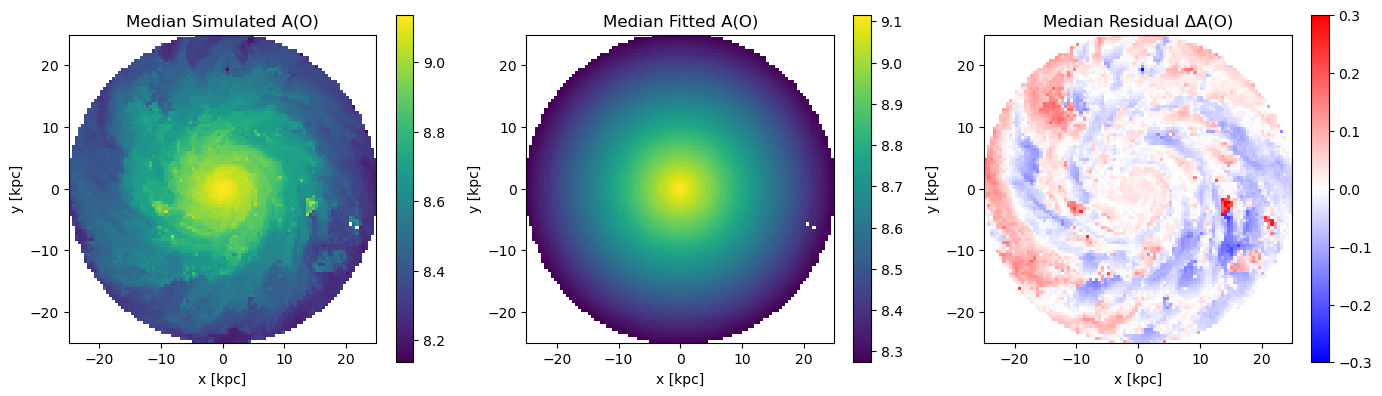

In [71]:
# Define bins for x-y plane
nbins = 100
x_edges = np.linspace(x.min(), x.max(), nbins+1)
y_edges = np.linspace(y.min(), y.max(), nbins+1)

# Compute 2D median maps
AO_median_map = np.zeros((nbins, nbins))
AO_fit_map = np.zeros((nbins, nbins))
residual_map = np.zeros((nbins, nbins))

for i in range(nbins):
    for j in range(nbins):
        mask = (x >= x_edges[i]) & (x < x_edges[i+1]) & (y >= y_edges[j]) & (y < y_edges[j+1])
        if np.any(mask):
            AO_median_map[j,i] = np.median(AO[mask])
            AO_fit_map[j,i] = np.median(AO_fit[mask])
            residual_map[j,i] = np.median(residuals[mask])
        else:
            AO_median_map[j,i] = np.nan
            AO_fit_map[j,i] = np.nan
            residual_map[j,i] = np.nan

# Plot 3-panel figure
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

im0 = ax[0].imshow(AO_median_map, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis', aspect='equal')
ax[0].set_title('Median Simulated A(O)')
fig.colorbar(im0, ax=ax[0])


im1 = ax[1].imshow(AO_fit_map, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis', aspect='equal')
ax[1].set_title('Median Fitted A(O)')
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(residual_map, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='bwr', aspect='equal', vmin=-0.3, vmax=0.3)
ax[2].set_title('Median Residual ΔA(O)')
fig.colorbar(im2, ax=ax[2])

for a in ax:
    a.set_xlabel('x [kpc]')
    a.set_ylabel('y [kpc]')

plt.tight_layout()
plt.savefig('figures/xy_median_maps.png')
plt.show()

<span style="color:pink">
5) Describe your choice of 2D bins. Discuss what details would be missed with fewer
bins or problems encountered with more bins.<br>  </span>




<span style="color:cyan">
Bins: 100x100 gives good spatial resolution. Fewer bins → lose details, more bins → noisy or empty cells.


<span style="color:pink">
6) Analyze the residuals in more detail and propose an explanation for any patterns
you observe.<br>
</span>
<span style="color:cyan">

### Analysis of Residuals<br>
The residual map (right panel) shows that the deviations from the linear radial metallicity fit are not random but display clear, structured patterns:

- **Spiral-like features**:  
  The residuals trace the spiral arms, with alternating regions of positive (red) and negative (blue) values.  
  - *Positive residuals*: the model underestimates the metallicity.  
  - *Negative residuals*: the model overestimates the metallicity.

- **Radial dependence**:  
  - In the **inner disk** (R ≲ 5–10 kpc), residuals are relatively small, suggesting the linear fit captures the trend reasonably well.  
  - In the **outer disk** (R ≳ 15 kpc), residuals are larger (up to ±0.3 dex), indicating the linear model does not account for gradient flattening or irregularities.

- **Localized clumps**:  
  Small-scale residual patches likely correspond to star-forming regions where stellar feedback enriched the gas more than average.


### Possible Explanations

1. **Spiral arm enrichment**  
   Spiral arms are sites of ongoing star formation. Supernovae and stellar winds inject heavy elements into the interstellar medium, leading to localized metal enhancements (positive residuals).

2. **Gas inflows and outflows**  
   - Radial inflows of low-metallicity gas dilute the metallicity in some regions (negative residuals).  
   - Outflows and mixing from feedback can redistribute metals unevenly across the disk.

3. **Non-linear metallicity gradient**  
   The simple linear fit cannot capture the flattening of the metallicity profile in the outer disk, which explains the systematic residuals at large radii.

4. **Radial migration**  
   Stars and gas clouds can migrate radially due to interactions with spiral arms or the galactic bar, smoothing the overall gradient but leaving behind substructures in the residuals.
   </span>
